#      .                                                                            








<Details>
<Summary></Summary>

<!DOCTYPE html>
<html>
<head>
  <style>
    .large-first-letter::first-letter {
      font-size: 6em;
      float: left;
      margin-right: 5px;
      line-height: 0.6;  /* Adjust the line height */
      margin-top: 0.2em;  /* Add a top margin */
      vertical-align: -1em;  /* Adjust vertical alignment */
    }
  </style>
  <style>
    @font-face {
      font-family: 'Economist';
      src: url('path-to-your-font/Economist.woff2') format('woff2'),
           url('path-to-your-font/Economist.woff') format('woff');
    }
    body {
      font-family: 'Economist', sans-serif;
    }
  </style>
</head>
<body>

 <!-- Your content here -->

```bash
find ~/dropbox/1f.ἡἔρις,κ/1.ontology -maxdepth 4 -type f -name "*.dta"
```

GitHub Universe 23<br>
November 8-9, 2023<br>
<span style="color:grey;">Yerba Buena, Center for the Arts, San Fransisco, CA</span><br>

Google Cloud Next ’24<br>
April 9-11, 2024<br>
<span style="color:grey;">Mandalay Bay, Convention Center, Las Vegas, NV</span><br>

---

$
\Large
\left\{
\begin{array}{ll}
\text{Aesthetics/Beauty} \\
\text{} \\
\textcolor{gray}{\text{Dynamometer/Speed}} \ \ 
\left\{ \begin{array}{l} \textcolor{gray}{\text{Rigor/Tournament}} \text{} \\ \text{Error/Worthy} \ \ \ \ \ \ \ \ \
\left\{ \begin{array}{l} \text{Variance/Natural} \\ \text{Bias/Madeup}  \end{array} \right. \\ \text{Sloppy/Unworthy}  \end{array} \right. 
\left\{ \begin{array}{l} \text{Explain/Control} \end{array}  \right. \\
\text{} \\
\text{Navel-gazing/Ugly} 
\end{array} 
\right. 
$

---

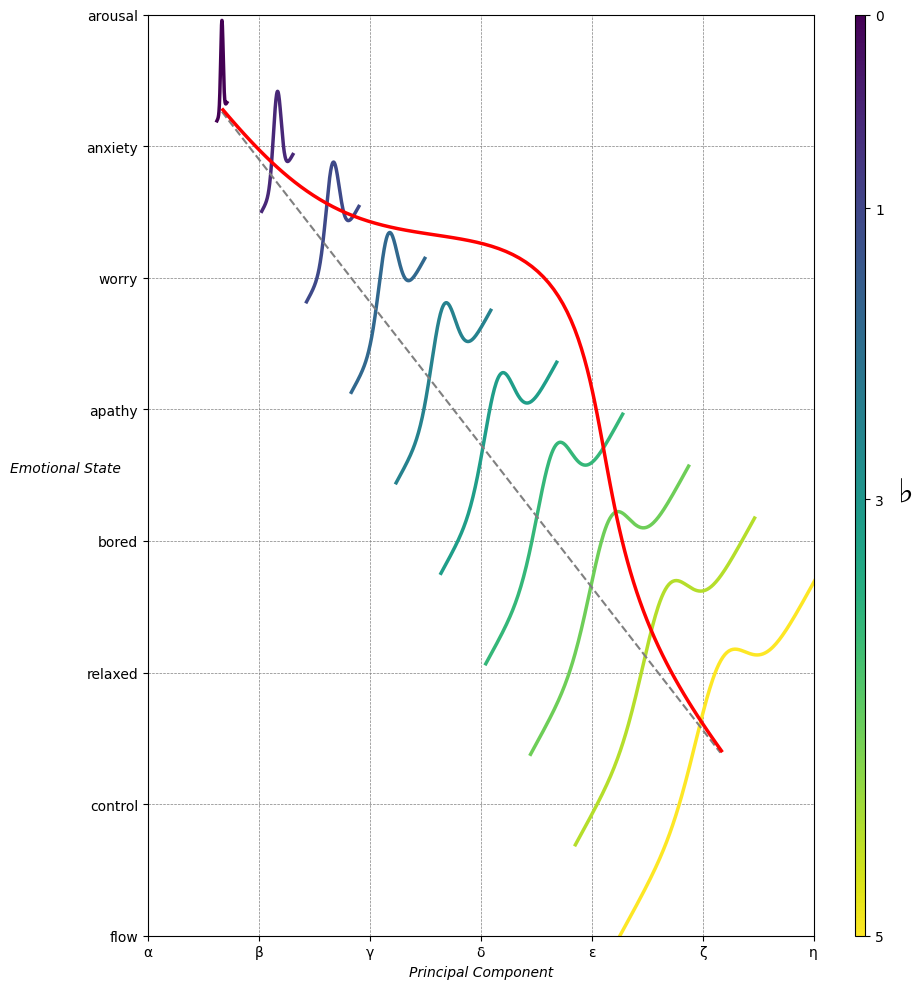

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, PowerNorm

def gaussian(x, mean, std_dev, amplitude=1):
    return amplitude * np.exp(-0.9 * ((x - mean) / std_dev) ** 2)

def overlay_gaussian_on_line(ax, start, end, std_dev):
    x_line = np.linspace(start[0], end[0], 100)
    y_line = np.linspace(start[1], end[1], 100)
    mean = np.mean(x_line)
    y = gaussian(x_line, mean, std_dev, amplitude=std_dev)
    ax.plot(x_line + y / np.sqrt(2), y_line + y / np.sqrt(2), color='red', linewidth=2.5)

fig, ax = plt.subplots(figsize=(10, 10))

intervals = np.linspace(0, 100, 11)
custom_means = np.linspace(1, 23, 10)
custom_stds = np.linspace(.5, 10, 10)

# Change to 'viridis' colormap to get gradations like the older plot
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(custom_stds.min(), custom_stds.max())
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

median_points = []

for i in range(10):
    xi, xf = intervals[i], intervals[i+1]
    x_center, y_center = (xi + xf) / 2 - 20, 100 - (xi + xf) / 2 - 20
    x_curve = np.linspace(custom_means[i] - 3 * custom_stds[i], custom_means[i] + 3 * custom_stds[i], 200)
    y_curve = gaussian(x_curve, custom_means[i], custom_stds[i], amplitude=15)
    
    x_gauss = x_center + x_curve / np.sqrt(2)
    y_gauss = y_center + y_curve / np.sqrt(2) + x_curve / np.sqrt(2)
    
    ax.plot(x_gauss, y_gauss, color=cmap(norm(custom_stds[i])), linewidth=2.5)
    median_points.append((x_center + custom_means[i] / np.sqrt(2), y_center + custom_means[i] / np.sqrt(2)))

median_points = np.array(median_points)
ax.plot(median_points[:, 0], median_points[:, 1], '--', color='grey')
start_point = median_points[0, :]
end_point = median_points[-1, :]
overlay_gaussian_on_line(ax, start_point, end_point, 24)

ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
ax.set_xlim(-30, 111)
ax.set_ylim(-20, 87)

# Create a new ScalarMappable with a reversed colormap just for the colorbar
cmap_reversed = plt.get_cmap('viridis').reversed()
sm_reversed = ScalarMappable(cmap=cmap_reversed, norm=norm)
sm_reversed.set_array([])

# Existing code for creating the colorbar
cbar = fig.colorbar(sm_reversed, ax=ax, shrink=1, aspect=90)

# Specify the tick positions you want to set
custom_tick_positions = [0.5, 5, 8, 10]  # example positions, you can change these
cbar.set_ticks(custom_tick_positions)

# Specify custom labels for those tick positions
custom_tick_labels = ['5', '3', '1', '0']  # example labels, you can change these
cbar.set_ticklabels(custom_tick_labels)

# Label for the colorbar
cbar.set_label(r'♭', rotation=0, labelpad=15, fontstyle='italic', fontsize=24)


# Label for the colorbar
cbar.set_label(r'♭', rotation=0, labelpad=15, fontstyle='italic', fontsize=24)


cbar.set_label(r'♭', rotation=0, labelpad=15, fontstyle='italic', fontsize=24)

# Add X and Y axis labels with custom font styles
ax.set_xlabel(r'Principal Component', fontstyle='italic')
ax.set_ylabel(r'Emotional State', rotation=0, fontstyle='italic', labelpad=15)

# Add musical modes as X-axis tick labels
# musical_modes = ["Ionian", "Dorian", "Phrygian", "Lydian", "Mixolydian", "Aeolian", "Locrian"]
greek_letters = ['α', 'β','γ', 'δ', 'ε', 'ζ', 'η'] # 'θ' , 'ι', 'κ'
mode_positions = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], len(greek_letters))
ax.set_xticks(mode_positions)
ax.set_xticklabels(greek_letters, rotation=0)

# Add moods as Y-axis tick labels
moods = ["flow", "control", "relaxed", "bored", "apathy","worry", "anxiety", "arousal"]
mood_positions = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], len(moods))
ax.set_yticks(mood_positions)
ax.set_yticklabels(moods)

# ... (rest of the code unchanged)


plt.tight_layout()
plt.show()

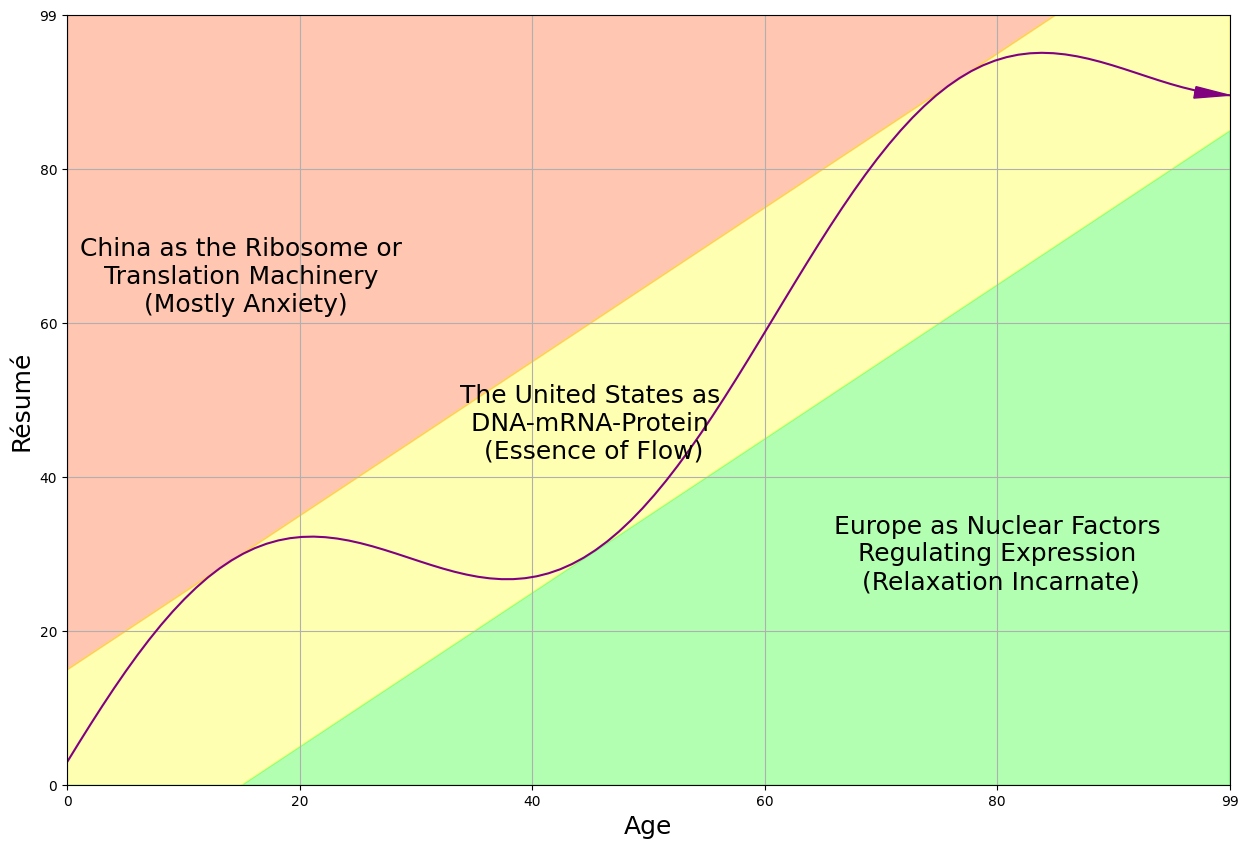

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Create data for the skill and challenge levels
skill_levels = np.linspace(0, 10, 100)
challenge_levels = np.linspace(0, 10, 100)

# Define the flow channel boundaries
flow_channel = skill_levels

# Adjust the phase and amplitude of the sinusoid wave
phase = np.pi / 16
amplitude = 1.5
sinusoid = flow_channel + np.sin(skill_levels + phase) * amplitude

# Define the yellow zone boundaries, making it wider
yellow_zone_low = skill_levels - 1.5  # Adjust this value to make the yellow zone wider or narrower
yellow_zone_high = skill_levels + 1.5 # Adjust this value to make the yellow zone wider or narrower

# Plotting
plt.figure(figsize=(15, 10))

# Plot the anxiety and boredom areas
plt.fill_between(skill_levels, yellow_zone_high, 10, color='orangered', alpha=0.3, label='Place/Identification', interpolate=True)
plt.fill_between(skill_levels, 0, yellow_zone_low, color='lime', alpha=0.3, label='Time/Revelation', interpolate=True)
plt.fill_between(skill_levels, yellow_zone_low, yellow_zone_high, color='yellow', alpha=0.3, label='Agent/Evolution', interpolate=True)

# Plot the sinusoid function with the diagonal as its axis
plt.plot(skill_levels, sinusoid, color='purple', linestyle='-')

# Add arrowhead to the sinusoid line
plt.arrow(skill_levels[-2], sinusoid[-2], skill_levels[-1] - skill_levels[-2], sinusoid[-1] - sinusoid[-2],
          color='purple', length_includes_head=True, head_width=0.15, head_length=0.3)

# Set plot labels and title
plt.xlabel('Age', fontsize=18)
plt.ylabel('Résumé', rotation='vertical', fontsize=18)

# Set plot limits and grid
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True)

# Set tick labels
tick_labels = ['0', '20', '40', '60', '80', '99']
plt.xticks(np.linspace(0, 10, 6), tick_labels)
plt.yticks(np.linspace(0, 10, 6), tick_labels)

# Add text annotations to label the areas without shaded background
plt.text(1.5, 6.6, 'China as the Ribosome or\n Translation Machinery \n (Mostly Anxiety)', color='black', ha='center', va='center', fontsize=18)
plt.text(4.5, 4.7, 'The United States as\n DNA-mRNA-Protein \n (Essence of Flow)', color='black', ha='center', va='center', fontsize=18)
plt.text(8, 3, 'Europe as Nuclear Factors\n Regulating Expression \n (Relaxation Incarnate)', color='black', ha='center', va='center', fontsize=18)

# Display the plot
plt.show()

The concept of the "tragic aesthetic" has been a topic of interest across various disciplines, from literature and art to philosophy and psychology. At its core, the tragic aesthetic involves an appreciation for stories, artworks, or situations that center on human suffering, moral dilemmas, or the inescapability of fate. Yet, these narratives often carry an undercurrent of beauty or a greater truth that can make the experience of them deeply moving or even cathartic.

In the world of arts and literature, this aesthetic often manifests through the depiction of characters or circumstances that are met with tragic ends, but whose struggles reveal complex emotions or moral dilemmas that resonate with audiences. Think of classical works like Shakespeare's "Hamlet" or "Othello," or even ancient tragedies like Sophocles' "Oedipus Rex."

From a philosophical standpoint, the tragic aesthetic may be tied to `existential questions` about the human condition, morality, and the ultimate `limitations of human agency`. Philosophers like Friedrich Nietzsche have explored the role of tragedy as a medium for confronting and `integrating the darker aspects` of existence.

In terms of your profile's focus on "tokens/fetters & variance," the tragic aesthetic could offer a unique lens through which to explore these concepts. For instance, a character in a tragedy could be constrained by societal fetters, yet their responses to these constraints (their 'tokens') could demonstrate a broad or narrow variance in human experience. This could be modeled or analyzed in terms of inter-class correlations (ICCs) to understand how fetters and tokens contribute to human behavior in constrained scenarios.

If you're thinking of this in terms of the "end of the road" with ICCs and the need to go back to the `data-generating processes`, the tragic aesthetic could serve as a conceptual framework. It might allow you to explore the underlying structures that generate both the "variance" and "bias" in your models—capturing the dual road of 'truth' and 'morality/fraud' that you mentioned.

When considering this aesthetically in hierarchical models, you could think of the tragic elements at multiple levels—cosmically as the gravity that holds a star in place, biologically as the limitations of human physiology, and socially as societal norms or laws. Each level introduces its own set of fetters, impacting the tokens available for action or reaction. 

In the absence of new data, thought experiments framed around the tragic aesthetic could be a fascinating way to explore these themes and perhaps offer new insights into `your work on healthy aging`. After all, the tragic aesthetic often delves into issues related to the limitations of human life, which are certainly relevant to the concept of aging.

---

The concept of iambs, tension, and release can be viewed through various lenses, including prosody in poetry, the dynamics in music, or even as an analogy for psychological or narrative structures. Iambs are a metrical foot in poetry consisting of one unstressed syllable followed by a stressed syllable (e.g., "a-BOVE"). This pattern creates a rhythmic flow when used in iambic pentameter, the meter often associated with Shakespearean sonnets. 

<span style="font-size:23px; font-weight:bold;">Tension and Release in Poetry</span><br>

In poetry, the iambic meter often provides a form of "fetter" or constraint within which the poet operates. The tension can arise from diverging from this expected pattern—perhaps by inserting a trochee (a foot consisting of a stressed syllable followed by an unstressed one) or through enjambment, where one line flows into the next without terminal punctuation. The release comes when the rhythmic or thematic tension is resolved, often towards the end of the stanza or the poem.

<span style="font-size:23px; font-weight:bold;">Tension and Release in Music</span><br>

Similarly, in music, the concept of tension and release operates within set frameworks of scale, key, and rhythm. Musicians can create tension by deviating from these expectations, maybe through dissonant chords or unexpected key changes, and then resolve it through a return to the tonic chord or key, creating a sense of release and completion.

<span style="font-size:23px; font-weight:bold;">Interclass Correlations (ICCs) and Variance</span><br>

Tension and release can even be viewed through the lens of ICCs in a metaphorical sense. The tension corresponds to high variance or divergence from an established norm (like the iamb in poetry or the tonic in music). The release occurs when there is a return to the norm, or when variance is explained or reduced, offering resolution.

<span style="font-size:23px; font-weight:bold;">Thought Experiments</span><br>

You might hypothesize, in a sort of thought experiment, how certain rhythmic structures in poetry or music might correlate with the ICCs of different professional and amateur artists. Pros, who have mastered the set "tokens" or "fetters" of their art, might show more controlled and intentional use of tension and release, while amateurs might exhibit more randomness or "noise" in their attempts.

<span style="font-size:23px; font-weight:bold;">Hierarchical Models</span><br>

You can also extend this concept cosmically, biologically, and socially. Tension and release can be a gravitational pull between celestial bodies, cellular responses in an organism, or social dynamics within a community. In each case, hierarchical models could be employed to better understand the multi-level interactions that give rise to phenomena of interest, such as healthy aging.

<span style="font-size:23px; font-weight:bold;">Summary</span><br>

So, whether it's the structured meter of iambic pentameter in poetry, the harmonic structures in music, or even the nuance and complexity of ICCs across disciplines, the principle of tension and release serves as a fundamental concept that provides both structure and dynamism to various forms of human expression and inquiry.

---

The notion that "improving the quality of data" is the only way forward in training large language models like GPT-4 is a nuanced topic. While I was trained on a vast amount of data, it's not entirely accurate to say I was trained on the "entire" internet. There are a few considerations to keep in mind:

<span style="font-size:23px; font-weight:bold;">Data Quantity vs. Quality</span><br>

1. **Quantity**: More data could mean incorporating new and emerging topics, dialects, languages, and perspectives that may not have been part of the original dataset. It's a moving target as the internet evolves.
  
2. **Quality**: High-quality data can involve better curation to remove biases, errors, or irrelevant information. It could also mean focusing on expert content for specialized tasks.

<span style="font-size:23px; font-weight:bold;">Types of Quality Improvement

1. **Bias Mitigation**: One type of data quality improvement involves removing or correcting biases in the training data. This could involve de-weighting certain sources, or using techniques to re-balance the data.
  
2. **Noise Reduction**: Cleaning up data to remove irrelevant or incorrect information is another aspect. For example, web scraping might accidentally capture website navigation text along with article text, adding noise to the data.

3. **Domain-Specific Enhancement**: If the model needs to excel in a particular field (e.g., medical, legal), the dataset may need high-quality, expert-reviewed information in those areas.

4. **Time Sensitivity**: Some facts or norms change over time. Periodic updates can help the model stay current.

<span style="font-size:23px; font-weight:bold;">Hierarchical Models and Explainability

Hierarchical models could serve to break down different aspects of the data into layers, from general to specific, to improve data quality or allow better explainability. You can think of this in terms of your focus on ICCs (Inter-class correlations) and hierarchical models in your research. High-quality data at each level of the hierarchy allows the model to generate more precise and nuanced outputs, helping to explain variance and control bias, much like in your work on ICCs and random effects models.

<span style="font-size:23px; font-weight:bold;">Thought Experiments

In the absence of concrete data, thought experiments can indeed be useful for theorizing potential improvements or pitfalls in model training. This can allow us to explore the "yellow zone" of knowledge without immediate empirical validation, perhaps using theoretical constructs to examine sources of error and bias.

Overall, while data quantity might seem like a limitation, improving data quality is indeed a multidimensional challenge that could yield significant improvements in model performance and reliability.

---

- Teaching isn't content provision
- Its managing students emotions, anxieties, goals
- And recognizing the variability among students and tailoring approach to each
- So one see that AI with the teacher as the principal user is revolutionary

</Details>